<a href="https://colab.research.google.com/github/cjstewart/hyperspectral-project/blob/colab/pipeline_interface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image DownSampler Pipeline Interface
#### v_0.9
#### Created: 2021/03/31
#### Updated: 2021/06/17
#### Created by: Chris Stewart

#### __Overview:__ The purpose of this notebook is to serve as the interface for the downSampler pipeline. It exposes the pipeline's parameters to the user to modify as needed, as well as displays feedback about the pipeline run state, and handles some basic wrapper and drive mounting functions.
#### - Please take a moment to enjoy the following inspirational image of a pipeline:

pipeline-1200x790.jpg

image source: https://celdf.org/wp-content/uploads/2015/08/pipeline-1200x790.jpg

![alt text](img/pipeline-1200x790.jpg)

image source: https://celdf.org/wp-content/uploads/2015/08/pipeline-1200x790.jpg

## Instructions for Usage:

The downSampler pipeline allows images from the aerial NEON image platform to be processed into a closer representation of simulated hyperspectral satellite imagery.
It specifically uses NEON's "Spectrometer orthorectified surface directional reflectance - mosaic" dataset which can be found and downloaded from here: https://data.neonscience.org/data-products/DP3.30006.001

If you need help locating imagery use: https://www.geoplaner.com/

There are many sites and other filters that allow to selecting certain areas, dates, etc. One limitation however is that there may be no/limited coverage for some areas.

Once you have downloaded the data sets you want, unzip the data folder and copy it into the "pipeline_input" folder located in: code_working_dir > hyperspectral-project > data > pipeline_input. The downsampled and rebanded processed hdf5 and preview image files will be saved in the "pipeline_output" folder (next to the input one).

Important Note: Once you have processed the input data files, move them out of the pipeline_input folder or the next time the pipeline is run they will be processed again (likely undesired).

Citation for Rocky Mountain Site Data: National Ecological Observatory Network. 2021. Data Product DP3.30006.001, Spectrometer orthorectified surface directional reflectance - mosaic. Provisional data downloaded from http://data.neonscience.org on April 1, 2021. Battelle, Boulder, CO, USA NEON. 2021.

To run all code sequentially press ctrl+F10

### 1. Installation Code:

We require some specialized software packages and specific versions, so we need to install them by running the below code cells. NOTE: the ipython kernal will restart after the first cell, this gives a scary warning message ("Your session has crashed!") - don't worry it hasn't crashed it is simply restarting.

In [1]:
isColab = False # toggle this for colab or local (colab = True, local = false)

In [2]:
if isColab: # check flag for colab instance
    !pip install -q condacolab
    import condacolab
    condacolab.install_miniconda()

In [3]:
isColab = False # toggle this for colab or local (colab = True, local = false) - reset flag after kernal reloads
if isColab:
    import condacolab
    condacolab.check()

### 2. Mount Drive Code:
Next we mount the data drive to be able to read/write our data files and images. There will be a google authentication step that you must approve to proceed.

In [4]:
import os
import sys
from pathlib import Path
import logging
root_logger = logging.getLogger()
root_logger.setLevel(level=logging.INFO)
logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s', 
                    datefmt='%m/%d/%Y %I:%M:%S %p', 
                    level=logging.INFO,
                    filename="./info_nb.log")

logging.info('Pipeline workbook started')

if isColab: # colab instance
    # special code cell to mount google drive and change to the correct directory
    import os
    from google.colab import drive
    drive.mount('/content/gdrive/', force_remount=True) # mount google drive

    os.chdir('/content/gdrive/MyDrive/code_working_dir/hyperspectral-project/notebooks')


    module_path = os.path.abspath(os.path.join('..')) # add the projects src code directory to the sys path to allow finding our module
    if module_path not in sys.path:
        sys.path.append(module_path+"/src/data")
    
else: # local machine
    module_path = os.path.abspath(os.path.join('..')) # add the projects src code directory to the sys path to allow finding our module
    if module_path not in sys.path:
        sys.path.append(module_path+"\\src\\data")
        import downSampler # load pipeline module

### 3. Package Environment Setup Code:
We will load further code packages read from an environment .YAML file to ensure we get the right package versions and dependancies. There will be some downloading and it may take a few minutes.

In [5]:
os.getcwd() # check where we are

'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\notebooks'

In [6]:
if isColab:
    !conda env update -n base -f environment_colab4.yml #--prune # load more packages from environment file

In [7]:
# Export env - for testing
#!conda env export -n base > '/content/gdrive/MyDrive/code_working_dir/hyperspectral-project/environment_TEST4.yml'

### Parameters:

The pipeline parameters include:
- data_dir_path : this is the input data directory where the pipeline will search for .h5 files to downsample
- output_data_path : this is where the pipeline will output the downsampled .h5 files and corresponding preview images (in their own respective sub-folders)
- desired_GSD : this is the desired Ground Sample Distance (GSD) to downsample to in m. Note: should be an integer >= 1 m
- desired_band_centres : this is the input band centres for the spectral re-banding portion in um. Default: [0.505, 0.526, 0.544, 0.565, 0.586, 0.606, 0.626, 0.646, 0.665, 0.682, 0.699, 0.715, 0.730, 0.745, 0.762, 0.779, 0.787, 0.804]
- nodata_thres : this is the allowable threshold for missing data in an image for it to be processed - if an image is missing more than this fraction of its total data it will not be processed and will be skipped.


These are all fairly standard so likely will not need to be changed.

In [8]:
# parameter setup:
import downSampler
data_dir_path = Path(os.getcwd()).parents[0] / 'data' / 'pipeline_input' # path to input data files
output_data_path = Path(os.getcwd()).parents[0] / 'data' / 'pipeline_output' # path to input data files

desired_GSD = 5 # GSD in m
desired_band_centres = [0.505, 0.526, 0.544, 0.565, 0.586, 0.606, 0.626, 0.646, 0.665, 0.682, 0.699, 0.715, 0.73, 0.745, 0.762, 0.779, 0.787, 0.804]
# Our bands: [0.505, 0.526, 0.544, 0.565, 0.586, 0.606, 0.626, 0.646, 0.665, 0.682, 0.699, 0.715, 0.73, 0.745, 0.762, 0.779, 0.787, 0.804]

nodata_thres = 0.5 # fraction of allowable missing data
output_mode = 'geotiff' # sets the file type output

print("Parameters set!")

Parameters set!


### Find Input Files:

In [9]:
print("These are the input files found in the pipeline_input folder, ready to be processed:")
files_to_process = downSampler.find_files(data_dir_path)
for k in files_to_process.keys():
    print(k)

These are the input files found in the pipeline_input folder, ready to be processed:
Finding data files...
NEON_D06_UKFS_DP3_305000_4323000_reflectance.h5


### Process Images:
Running the next code cell starts processing the image data. NOTE: depending on how many images are in the pipeline_input folder this might take a while - sit back and relax!

Parameters set...
Finding data files...
Input files found...


Processing image(s):   0%|                                                                                                                                     | 0/1 [00:00<?, ?it/s]

Processing file:  NEON_D06_UKFS_DP3_305000_4323000_reflectance.h5
File loaded...
Downsampling image...
Downsampling complete!
Generating STAC metadata file...
Generating preview image...


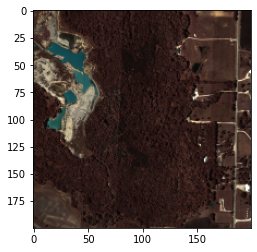

Generating thumbnail image...


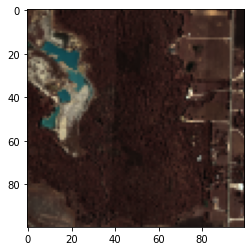

Metadata file generated
STAC metadata file generated!
Generating geotiff image files...


Processing image(s): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:44<00:00, 344.09s/it]

Geotiff image files generated!
--------------------------------------------------
All Processing Completed!
--------------------------------------------------


In [10]:
# params: data_dir_path, output_data_path, desired_band_centres, desired_GSD = 5, nodata_thres = 0.5, output_mode = 'geotiff'
downSampler.pipeline(data_dir_path, output_data_path, desired_band_centres, desired_GSD, nodata_thres, output_mode)